Cross-Validation Scores: [0.84542212 0.83115339 0.84661118 0.83828775 0.8452381 ]
Average Cross-Validation Score: 0.841342506086858
Standard Deviation of Cross-Validation Scores: 0.005877539624604332
Training Accuracy Score: 0.9914367269267365
Test Accuracy Score: 0.826955074875208
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1263
           1       0.77      0.60      0.68       540

    accuracy                           0.83      1803
   macro avg       0.81      0.76      0.78      1803
weighted avg       0.82      0.83      0.82      1803

Test Set Precision Score: 0.7688679245283019
Test Set Recall Score: 0.6037037037037037
Test Set F1 Score: 0.6763485477178424
Test Set ROC-AUC Score: 0.7630553356206563
Test Set Confusion Matrix:
[[1165   98]
 [ 214  326]]


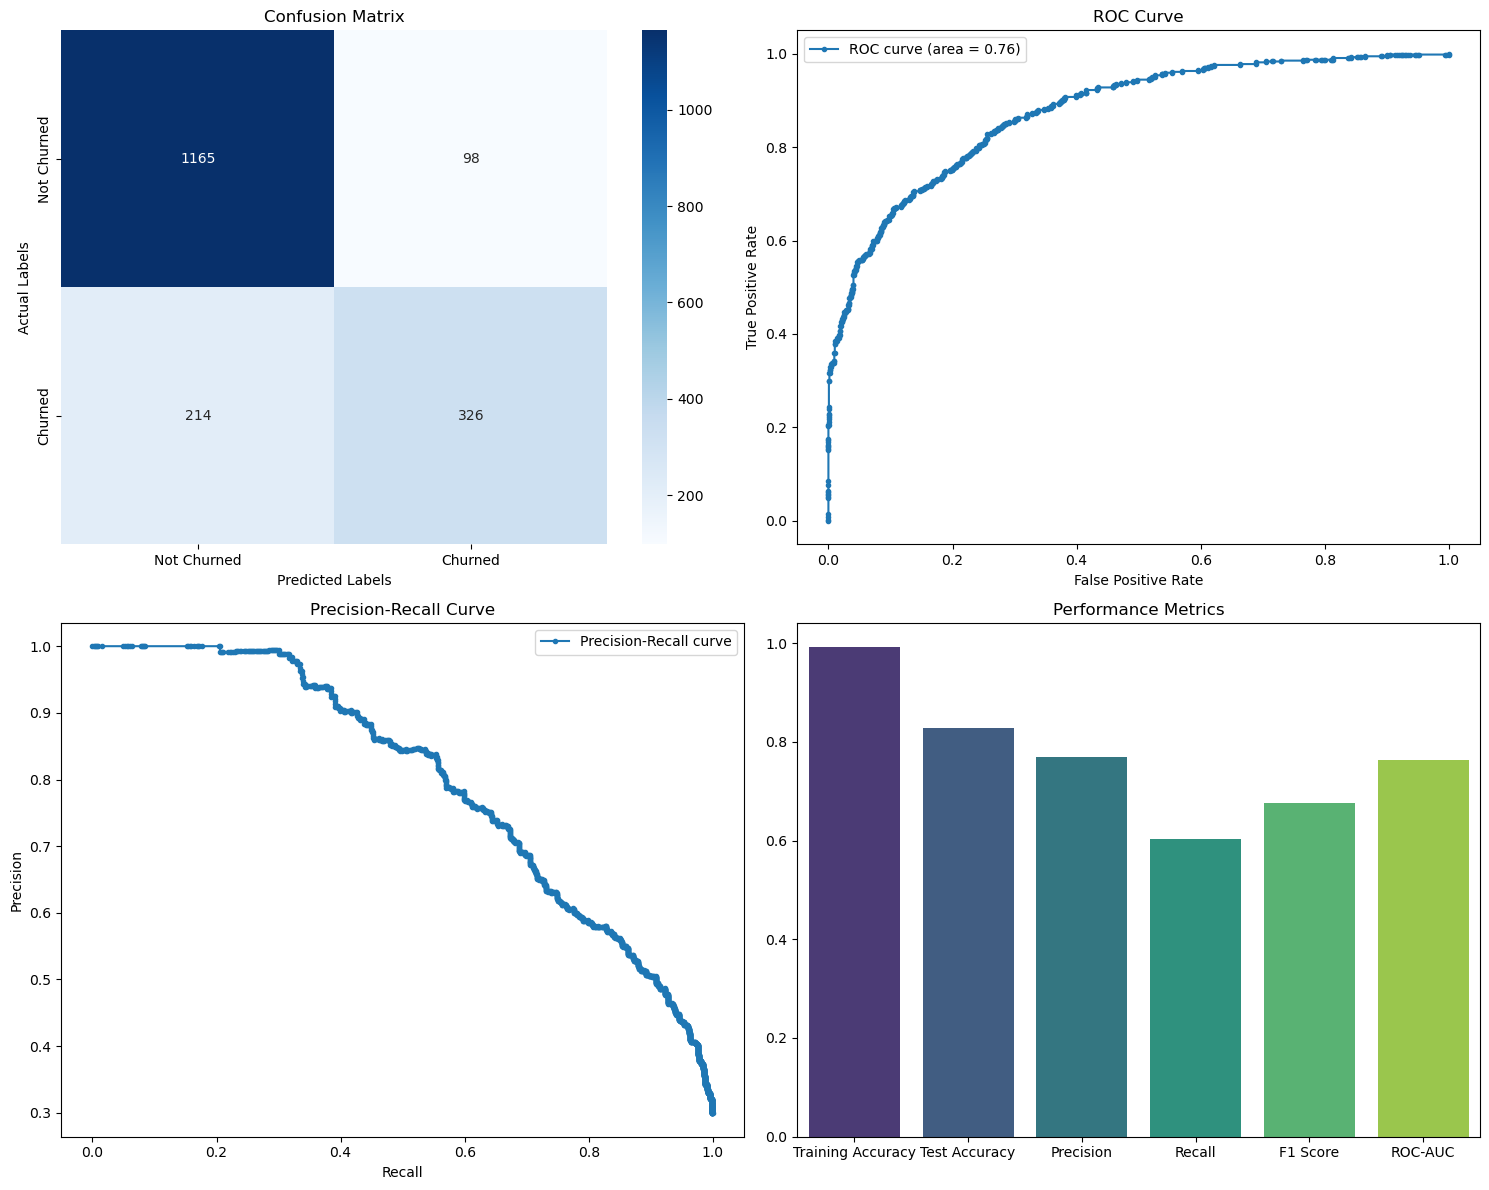

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve

churn_stay_df = pd.read_csv('churn_stay.csv')
churn_stay_df['Churn_Status'] = churn_stay_df['Customer_Status'].apply(lambda x: 1 if x == 'Churned' else 0)
data = churn_stay_df.drop(['Customer_ID', 'Churn_Category', 'Churn_Reason'], axis=1)

# Encoding categorical features
columns_to_encode = ['Gender', 'Married', 'State', 'Value_Deal', 'Phone_Service', 'Multiple_Lines',
                      'Internet_Service', 'Internet_Type', 'Online_Security', 'Online_Backup',
                      'Device_Protection_Plan', 'Premium_Support', 'Streaming_TV', 'Streaming_Movies',
                      'Streaming_Music', 'Unlimited_Data', 'Contract', 'Paperless_Billing',
                      'Payment_Method']

label_encoders = {col: LabelEncoder().fit(data[col]) for col in columns_to_encode}
for col in columns_to_encode:
    data[col] = label_encoders[col].transform(data[col])

X = data[['Contract', 'Total_Revenue', 'Total_Long_Distance_Charges', 'Total_Charges', 'Online_Security',
         'Premium_Support', 'Internet_Service', 'Paperless_Billing', 'Value_Deal', 'Monthly_Charge', 'Age', 'Payment_Method']]
y = data['Churn_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# The model
clf = GradientBoostingClassifier(n_estimators=300, learning_rate=0.01, max_depth=10, random_state=42)

# Apply cross-validation
cv_scores = cross_val_score(clf, X_train, y_train, cv=5)  
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print(f'Cross-Validation Scores: {cv_scores}')
print(f'Average Cross-Validation Score: {cv_mean}')
print(f'Standard Deviation of Cross-Validation Scores: {cv_std}')

# Fit the model on the entire training set
clf.fit(X_train, y_train)

# Predict on training and test data
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# Metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# ROC Curve
y_test_prob = clf.predict_proba(X_test)[:, 1]  # Probabilities for ROC and PR curves
fpr, tpr, _ = roc_curve(y_test, y_test_prob)

# Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_test_prob)

# Print metrics
print(f'Training Accuracy Score: {train_accuracy}')
print(f'Test Accuracy Score: {test_accuracy}')
print('Test Set Classification Report:')
print(classification_report(y_test, y_test_pred))
print(f'Test Set Precision Score: {precision}')
print(f'Test Set Recall Score: {recall}')
print(f'Test Set F1 Score: {f1}')
print(f'Test Set ROC-AUC Score: {roc_auc}')
print('Test Set Confusion Matrix:')
print(conf_matrix)

# Plotting
plt.figure(figsize=(15, 12))

# Confusion Matrix
plt.subplot(2, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churned', 'Churned'], yticklabels=['Not Churned', 'Churned'])
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')

# ROC Curve
plt.subplot(2, 2, 2)
plt.plot(fpr, tpr, marker='.', label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Precision-Recall Curve
plt.subplot(2, 2, 3)
plt.plot(recall_curve, precision_curve, marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

# Metrics Bar Plot
plt.subplot(2, 2, 4)
metrics = [train_accuracy, test_accuracy, precision, recall, f1, roc_auc]
metric_names = ['Training Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']
sns.barplot(x=metric_names, y=metrics, palette='viridis')
plt.title('Performance Metrics')

plt.tight_layout()
plt.show()


In [4]:
# The new dataset
new_data = pd.read_csv('joined.csv')

for col in columns_to_encode:
    new_data[col] = label_encoders[col].transform(new_data[col])

new_X = new_data[['Contract','Total_Revenue','Total_Long_Distance_Charges','Total_Charges','Online_Security',
         'Premium_Support','Internet_Service','Paperless_Billing','Value_Deal','Monthly_Charge','Age','Payment_Method']]

new_data['Churn_Status'] = (clf.predict(new_X) > 0.5).astype(int).flatten()

new_data

,Customer_ID,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,...,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status,Churn_Category,Churn_Reason,Churn_Status
0,93520-GUJ,0,67,0,5,13,19,4,1,1,...,72.10,72.10,0.0,0,7.77,79.87,Joined,Others,Others,0
1,57256-BIH,0,18,0,2,9,7,5,1,0,...,19.85,57.20,0.0,0,9.36,66.56,Joined,Others,Others,1
2,72357-MAD,0,53,0,11,14,12,4,1,0,...,44.30,44.30,0.0,0,42.95,87.25,Joined,Others,Others,1
3,66612-KAR,0,58,1,9,11,18,5,1,0,...,19.95,58.00,0.0,0,8.07,66.07,Joined,Others,Others,1
4,22119-WES,1,31,1,21,5,5,5,1,0,...,20.05,33.70,0.0,0,3.62,37.32,Joined,Others,Others,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,31412-HAR,0,81,1,6,14,29,5,1,0,...,19.20,37.20,0.0,0,14.06,51.26,Joined,Others,Others,0
407,54997-UTT,0,55,0,19,7,23,5,1,0,...,44.00,44.00,0.0,0,26.15,70.15,Joined,Others,Others,1
408,56728-RAJ,1,40,0,16,0,1,5,1,0,...,45.60,45.60,0.0,0,37.44,83.04,Joined,Others,Others,1
409,47624-TAM,0,62,1,17,7,29,5,1,0,...,-5.00,189.10,0.0,0,100.59,289.69,Joined,Others,Others,1


In [5]:
new_data.to_excel('results_GB.xlsx')